In [1]:
import jax
import jax.numpy as np
import jax.scipy.stats as stats
import matplotlib.pyplot as plt
import numpy,pickle

from jax import jit
import pandas as pd
import blackjax

import sys,os,importlib,pdb
sys.path.append('/mnt/home/szheng/projects/util_code')
import gm

import scipy
from scipy.signal import find_peaks
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
from importlib import reload

import copy

%matplotlib inline

In [73]:
sess_name="e15_13f1_220117"
py_data_dir = "/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data"
fr_ = pickle.load(open(os.path.join(py_data_dir,'fr.p'),'rb'))
pos_bins = fr_['pos_bins']['lin']
bin_to_lin=np.concatenate([pos_bins[:-1,None],pos_bins[1:,None]],axis=1).mean(axis=1)

fr = fr_['df']['pyr']
# truncate the timepoints to only keep the non intertrial part
# lin_endpoints = [15,205]
# fr = fr.query(f'{lin_endpoints[1]}>=lin>={lin_endpoints[0]}')

fr_map_ = pickle.load(open(os.path.join(py_data_dir,'fr_map.p'),'rb'))['fr_map_trial']

In [74]:
unit_int = 31
unit_str = f'unit_{unit_int}'

unit_ind_in_pyr = 0

trial_ind_dict = dict(fr.groupby('visitedArm')['trial'].unique())
fr_map_one_unit_both_trials_dict = {k:val[unit_ind_in_pyr] for k,val in fr_map_.items()}
pars=gm.init_both_trial_types(fr_map_one_unit_both_trials_dict,trial_ind_dict,bin_to_lin=None)

pars_rand=gm.init_both_trial_types(fr_map_one_unit_both_trials_dict,trial_ind_dict,bin_to_lin=None,random_init=True)

In [4]:

import gm_glm_bayesian as glm
reload(glm)

<module 'gm_glm_bayesian' from '/mnt/home/szheng/projects/util_code/gm_glm_bayesian.py'>

In [75]:
%%time

regressors=glm.get_regressors(fr)
target = fr[unit_str].values
pars=gm.init_both_trial_types(fr_map_one_unit_both_trials_dict,trial_ind_dict,bin_to_lin=None,random_init=True)
# pars=gm.init_both_trial_types(fr_map_one_unit_both_trials_dict,trial_ind_dict,bin_to_lin=None,random_init=False)

sampler_func = blackjax.mala
sampler_kw = {'step_size':1e-2}
states=glm.fit(regressors,pars,target,sampler_func=sampler_func,sampler_kw=sampler_kw,mask=None,num_samples=1000,rng_key_int=0)


CPU times: user 12.8 s, sys: 4.01 ms, total: 12.8 s
Wall time: 12.8 s


In [78]:
jax.tree_map

<function jax._src.tree_util.tree_map(f: Callable[..., Any], tree: Any, *rest: Any, is_leaf: Optional[Callable[[Any], bool]] = None) -> Any>

In [79]:
pars_samples = jax.tree_map(lambda x:x[:int(x.shape[0]//2)],states.position)

In [134]:
logpdf = lambda pars: glm.logpdf_no_reg(regressors,pars,target,mask=None,noise_type="poisson")

ys_l = fr_map_[tr][unit_ind_in_pyr]
tr=0
pars_samples_trialtype = jax.tree_map(lambda x:x[:,trial_ind_dict[tr].astype(int)],pars_samples)
tr=0
ys_l = fr_map_[tr][unit_ind_in_pyr]
fhat_samples = vmap(gm.gm_func_by_trial,in_axes=(None,0))({'xs':np.arange(100)},pars_samples_trialtype)

In [113]:
fhat_samples_mean=fhat_samples.mean(axis=0)

In [140]:
ys_l.shape

(100, 21)

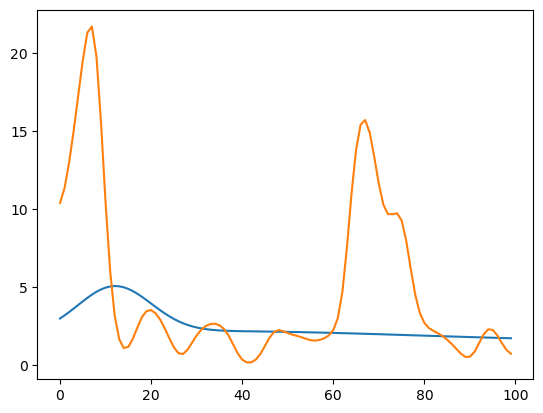

In [182]:
tt=20
# plt.plot(fhat_samples_mean[:,tt])
s=1600
plt.plot(fhat_samples[s,:,tt])
plt.plot(ys_l[:,tt])

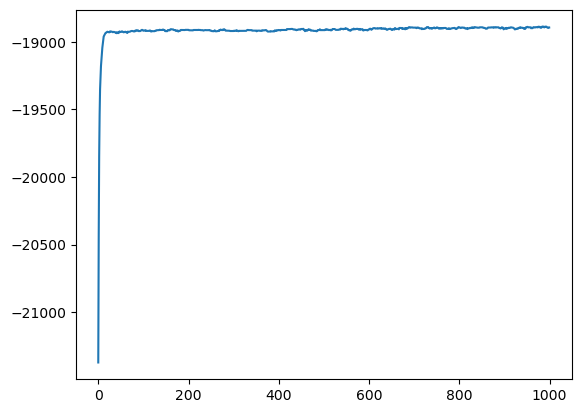

In [76]:
plt.plot(states.logprob)

In [95]:
fhat_samples.shape

(500, 55038)

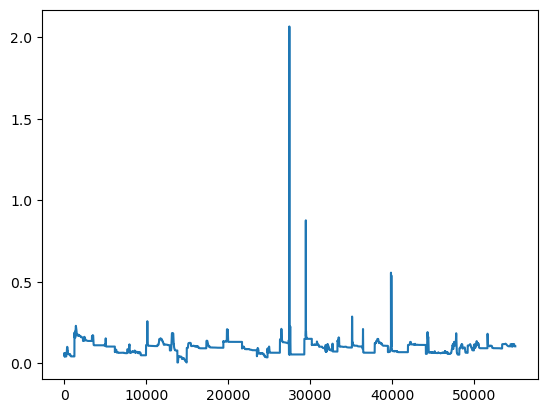

In [102]:
plt.plot(fhat_samples[5])

(0.0, 5.0)

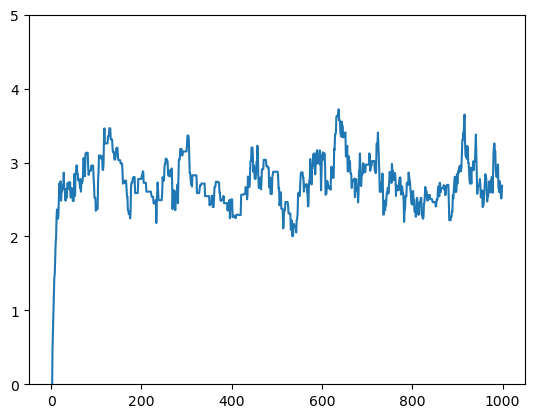

In [77]:
plt.plot(states.position['logb'][:,0])
plt.ylim([0,5])

In [9]:
import gm_plot as gp

In [13]:
pars_['logws'].shape

(21, 35, 2)

In [31]:
pars_samples_rand = states.position
pars_initial = {k:val[0] for k,val in pars_samples_rand.items()}
pars_end = {k:val[-1] for k,val in pars_samples_rand.items()}

(<Figure size 640x480 with 1 Axes>, <AxesSubplot:>, 14.52716227163636)

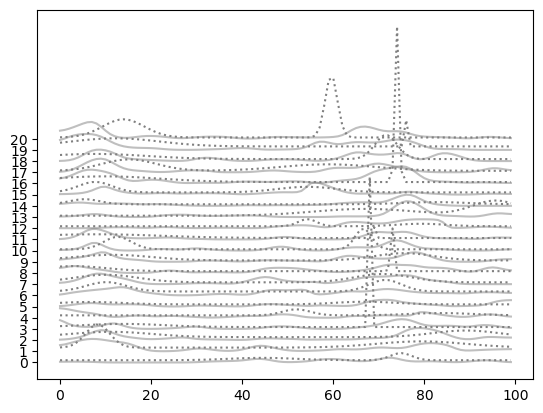

In [72]:
ii = -200
pars_ = {k:val[ii] for k,val in pars_samples_rand.items()}
tr=0
ys_l = fr_map_[tr][unit_ind_in_pyr]
pars_ = {k:val[trial_ind_dict[tr].astype(int)] for k,val in pars_.items()}
gp.plot_fit_original(ys_l,pars_,bin_to_lin=None,fig=None,ax=None,nooriginal=False,displacement=None)

In [27]:
blackjax.diagnostics.effective_sample_size(pars_samples_rand['logws'][None,...],chain_axis=0,sample_axis=1)

AssertionError: effective_sample_size as implemented only works for two or more chains.

In [38]:
reload(glm)

<module 'gm_glm_bayesian' from '/mnt/home/szheng/projects/util_code/gm_glm_bayesian.py'>

In [34]:
# deterministic
from jax.example_libraries import optimizers as jax_opt
from jax import value_and_grad, grad, jit, vmap, jacfwd, jacrev




def train_adam(func,regressors,pars,ys_l,noise_type='poisson',lr=0.1,niters=100,mask=None):
# def train_adam(func,*args,argnums=1,lr=0.1,niters=100,**kwargs):
    opt_init,opt_update,get_params=jax_opt.adam(lr)
    loss_l=[]
    @jit
    def train_step(step_i,opt_state):
        params=get_params(opt_state)
        loss,grads = value_and_grad(func,argnums=1)(regressors,params,ys_l,noise_type=noise_type,mask=mask) # notice the params here
        # loss,grads = value_and_grad(func,argnums=argnums)(*args,**kwargs) 
        return loss, opt_update(step_i, grads, opt_state)
    # opt_state=opt_init(args[argnums])
    opt_state=opt_init(pars)
    for ii in range(niters):
        loss,opt_state = train_step(ii,opt_state)
        loss_l.append(loss)
    return get_params(opt_state), np.array(loss_l)


In [56]:
%%time
pars=gm.init_both_trial_types(fr_map_one_unit_both_trials_dict,trial_ind_dict,bin_to_lin=None)
pars_ = pars
pars_learned,loss_l=train_adam(glm.negative_logpdf_no_reg, regressors,pars_,target,niters=10000,lr=0.1)

CPU times: user 1min 30s, sys: 155 ms, total: 1min 30s
Wall time: 1min 20s


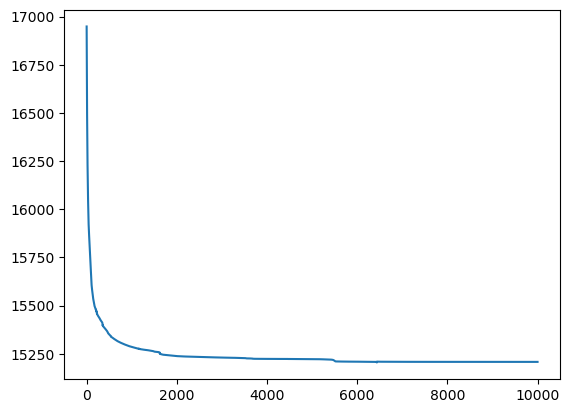

In [57]:
plt.plot(loss_l)

(<Figure size 640x480 with 1 Axes>, <AxesSubplot:>, 14.52716227163636)

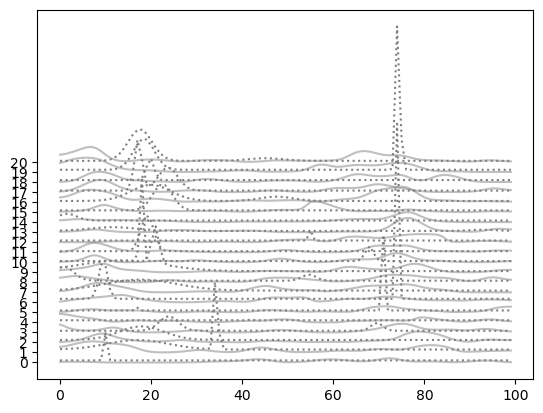

In [58]:
pars_ = pars_learned
tr=0
ys_l = fr_map_[tr][unit_ind_in_pyr]
pars_ = {k:val[trial_ind_dict[tr].astype(int)] for k,val in pars_.items()}
gp.plot_fit_original(ys_l,pars_,bin_to_lin=None,fig=None,ax=None,nooriginal=False,displacement=None)

In [59]:
regressors

{'position': DeviceArray([16.013308, 18.339264, 20.4863  , ..., 15.923848, 15.476549,
              15.02925 ], dtype=float32),
 'trial_inds_int': array([ 0,  0,  0, ..., 34, 34, 34]),
 'dt': 0.03333333333284827}

In [61]:
regressors['trial_inds_int'][1:1000]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,